In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from f3rm.minimal.interface import *
from f3rm.features.clip.clip import tokenize
from f3rm.features.clip_extract import CLIPArgs
from f3rm.features.clip import clip
import cv2
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
import math

In [2]:
# config_path = "outputs/stata_office/f3rm/2025-04-03_050224/config.yml"
config_path = "outputs/ahgroom_colmap/f3rm/2025-04-14_190026/config.yml"
nerfint = NERFinterface(config_path)

[10:05:40] Auto image downscale factor of 1                                                 ]8;id=895235;file:///opt/miniconda3/envs/f3rm/lib/python3.9/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=434864;file:///opt/miniconda3/envs/f3rm/lib/python3.9/site-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#349\349]8;;\

Setting up training dataset...

Caching 32 out of 4272 images, resampling every 128 iters.

Setting up evaluation dataset...

Caching 32 out of 224 images, resampling every 128 iters.

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/ahgroom_colmap/f3rm/2025-04-14_190026/nerfstudio_models/step-000119999.ckpt

In [3]:
up_table_frame = [-0.9721904271024854,0.23419192040271516,-1.387778837771707e-17,0,-0.13145933632821866,-0.5457212533710385,0.8275909172140401,0,0.19381509642125355,0.8045759266360382,0.5613316644722955,0,0.02624862066627097,0.20843032201619785,0.30019989352841997,1]
up_table_frame = nerfint.get_c2w_from_viewer(up_table_frame)

In [4]:
up_table_frame_44 = np.vstack((up_table_frame.numpy(), np.array([0, 0, 0, 1])))
# relative transformation
T1 = Homography.get_std_rot(axis="Z", alpha=np.deg2rad(-22))
T2 = Homography.get_std_trans(cz=0.75)
T = T2 @ T1
c2w_new_44 = up_table_frame_44 @ np.linalg.inv(T)
c2w_new = torch.from_numpy(c2w_new_44[:3, :4]).float().cpu()

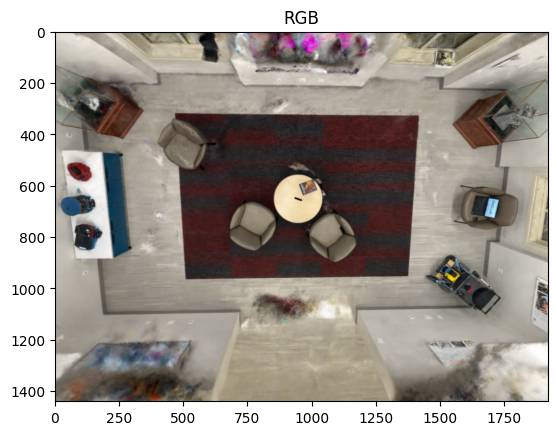

In [5]:
outputs = nerfint.get_custom_camera_outputs(
    fx=1150.0,
    fy=1150.0,
    width=1920,
    height=1440,
    c2w=c2w_new,
    fars=10.0,
    nears=1.1,
)
plt.imshow((outputs["rgb"].cpu().numpy() * 255).astype(np.uint8))
plt.title("RGB")
plt.show()

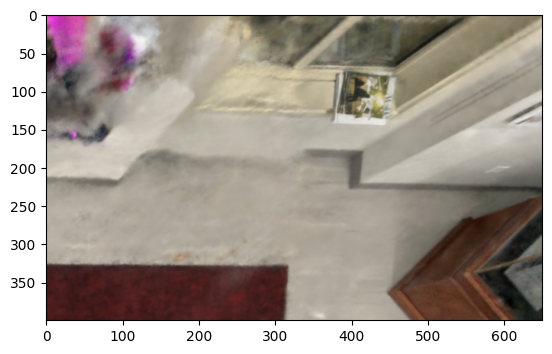

In [6]:
bev_full = np.asarray(Image.open("temp/bev_room.png").convert("RGB"))
bev_crop_window = bev_full[0:400, 1100:1750, :]
plt.imshow(bev_crop_window)

In [7]:
@torch.inference_mode()
def compute_similarity_text2vis(img_patch_descriptors, text_embeddings, has_negatives=False, softmax_temp=1.0):
    """
    Args:
        img_patch_descriptors: (**, dim)
        text_embeddings: (num_texts, dim). First entry is positive, rest (if any) are negatives.
        has_negatives: whether to apply paired softmax
        softmax_temp: temperature for softmax scaling

    Returns:
        sims: (**, 1) similarity score to the positive text(s) (normalized probability)
    """
    # Normalize
    img_patch_descriptors = img_patch_descriptors / img_patch_descriptors.norm(dim=-1, keepdim=True)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    raw_sims = img_patch_descriptors @ text_embeddings.T  # (**, num_texts)

    if not has_negatives:
        # Mean over positives (if multiple)
        if raw_sims.shape[-1] > 1:
            raw_sims = raw_sims.mean(dim=-1, keepdim=True)
        return raw_sims

    # Paired softmax setup: split pos/neg
    pos_sims, neg_sims = raw_sims[..., :1], raw_sims[..., 1:]
    pos_sims = pos_sims.expand_as(neg_sims)
    paired_sims = torch.cat([pos_sims, neg_sims], dim=-1)  # (**, num_negatives + 1)

    # Apply temperature-scaled softmax
    probs = (paired_sims / softmax_temp).softmax(dim=-1)[..., :1]  # get prob of positive
    torch.nan_to_num_(probs, nan=0.0)

    return probs  # (**, 1)


In [8]:
descriptors = outputs["feature"].cpu().half()
descriptors.shape

torch.Size([1440, 1920, 768])

In [9]:
clipmodel, _ = clip.load(CLIPArgs.model_name, device=nerfint.device)

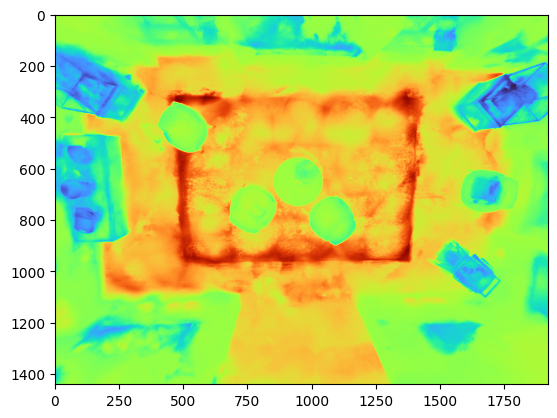

In [21]:
# Compute similarity between text and image patches
text_queries = ["floor", "object"]
text_tokens = tokenize(text_queries).to(nerfint.device)   # (num_texts, 77)
text_embds = clipmodel.encode_text(text_tokens)  # (num_texts, dim)
text_embds = text_embds.cpu()
sims = compute_similarity_text2vis(descriptors, text_embds, has_negatives=True, softmax_temp=0.07).squeeze()
plt.imshow(sims.cpu().numpy(), cmap="turbo")
plt.show()

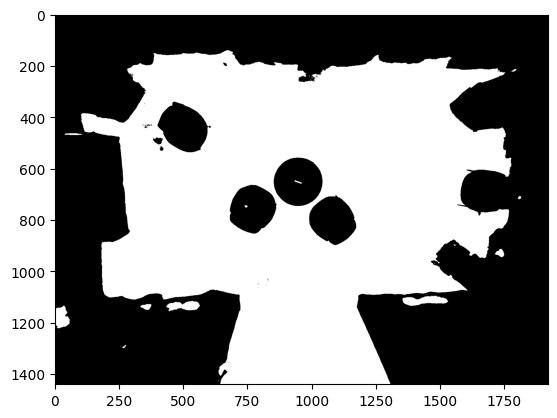

In [22]:
plt.imshow(sims.cpu().numpy() > 0.52, cmap="gray")

In [12]:
def plot_points_on_image(image_path, points, save_path='output.png'):
    if isinstance(image_path, str):
        img = Image.open(image_path).convert('RGB')
    else:
        img = image_path.convert('RGB')
    width, height = img.size

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Use default colormap
    colors = plt.cm.get_cmap('tab10')

    for i, (x, y) in enumerate(points):
        c1 = patches.Circle((x, y), 6, color=colors(3), fill=True)
        ax.add_patch(c1)
        c2 = patches.Circle((x, y), 16, color=colors(3), fill=False)
        ax.add_patch(c2)

    ax.axis('off')
    plt.tight_layout()
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

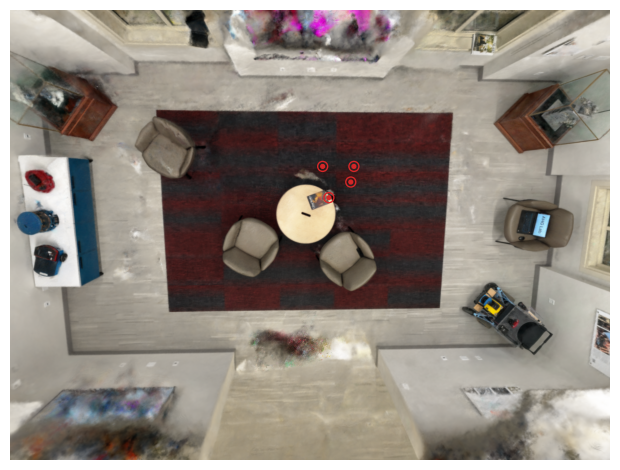

In [20]:
rgb_img = outputs["rgb"].cpu().numpy()
rgb_img = (rgb_img * 255).astype(np.uint8)
pil_img = Image.fromarray(rgb_img)
plot_points_on_image(pil_img, points=[(1100, 500), (1000, 500), (1020, 600), (1090, 550)], save_path=None)

In [ ]:
def generate_affordance_map(rgb_img, center_x, center_y, sigma=50):
    """
    Overlays a red affordance heatmap on the input RGB image using a 2D Gaussian centered at (center_x, center_y).
    """
    h, w, _ = rgb_img.shape
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    dist_sq = (xx - center_x) ** 2 + (yy - center_y) ** 2
    gaussian = np.exp(-dist_sq / (2 * sigma ** 2))
    gaussian = (gaussian / np.max(gaussian) * 255).astype(np.uint8)  # Normalize to [0, 255]

    red_overlay = np.zeros_like(rgb_img, dtype=np.uint8)
    red_overlay[..., 0] = gaussian  # Red channel only

    blended = cv2.addWeighted(rgb_img, 1.0, red_overlay, 1.0, 0)
    return blended

In [ ]:
redded = generate_affordance_map(rgb_img, 1350, 300, sigma=120)

In [ ]:
bothredgreen = generate_affordance_map(redded, 1100, 550, sigma=120)